# Lasso Regression and Inductive Conformal Prediction applied to the diabetes dataset

# Contents
# ~~~~~
### 1. Lasso Regression on sklearns diabetes dataset
### 2. Lasso Regression on the original diabetes dataset
### 3. Inductive Conformal Predictors
### 4. Results
# ~~~~~

### 1. Lasso Regression on sklearns diabetes dataset

In [1]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(diabetes.data, diabetes.target, random_state=1504)

In [3]:
from sklearn.linear_model import Lasso
lasso = Lasso().fit(X_train,y_train)
training_R_sqr = lasso.score(X_train,y_train)
test_R_sqr = lasso.score(X_test,y_test)

nr_of_coeff = sum(0 != lasso.coef_)

print("The training R squared and test R squared are: ", training_R_sqr , ",", test_R_sqr)
print("This model uses ",nr_of_coeff,"features. They're listed below:")
for i in range(len(lasso.coef_)):
    if lasso.coef_[i] != 0:
        print(diabetes.feature_names[i])

The training R squared and test R squared are:  0.34638413252253697 , 0.35427701131789957
This model uses  3 features. They're listed below:
bmi
bp
s5


### 2. Lasso Regression on the original diabetes dataset

In [4]:
import numpy as np
diabetes_data = np.genfromtxt('diabetes_data.txt', usecols=np.arange(10), skip_header=1)
diabetes_target = np.genfromtxt('diabetes_data.txt', usecols=10, skip_header=1)
X_train, X_test, y_train, y_test = train_test_split(diabetes_data, diabetes_target, random_state=1504)

In [5]:
lasso = Lasso().fit(X_train,y_train)
training_R_sqr = lasso.score(X_train,y_train)
test_R_sqr = lasso.score(X_test,y_test)

nr_of_coeff = sum(0 != lasso.coef_)

print("The training R squared and test R squared are: ", training_R_sqr , ",", test_R_sqr)
print("This model uses ",nr_of_coeff,"features. They're listed below:")
for i in range(len(lasso.coef_)):
    if lasso.coef_[i] != 0:
        print(diabetes.feature_names[i])

The training R squared and test R squared are:  0.5012095757779301 , 0.5314792176453547
This model uses  9 features. They're listed below:
age
sex
bmi
bp
s1
s2
s3
s5
s6


With the original, unscaled data there is both a higher Test R squared and Training R squared. Also the Lasso Regression with the original, unscaled data did not set any of the features to 0 and used all 9 features. Whereas the dataset from sklearn reduced down to just 3 features after Lasso was fitted.

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
lasso = Lasso().fit(X_train_scaled,y_train)
training_R_sqr = lasso.score(X_train_scaled,y_train)
test_R_sqr = lasso.score(X_test_scaled,y_test)

nr_of_coeff = sum(0 != lasso.coef_)

print("The training R squared and test R squared are: ", training_R_sqr , ",", test_R_sqr)
print("This model uses ",nr_of_coeff,"features. They're listed below:")
for i in range(len(lasso.coef_)):
    if lasso.coef_[i] != 0:
        print(diabetes.feature_names[i])

The training R squared and test R squared are:  0.5026484682221571 , 0.5349350288709731
This model uses  8 features. They're listed below:
age
sex
bmi
bp
s1
s3
s5
s6


These results are closer to the results obtained in the previous Lasso Regression, where the original unscaled data was used. This is because the data has been scaled down using only the training data here. In the first Lasso model the training data and the test data were both normalized at the same time, which caused data snooping. This data snooping caused errors in the model which led to the model setting too many features to zero and the R squared being low.

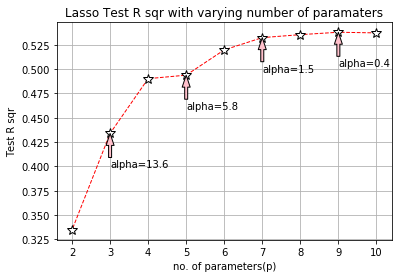

In [9]:
alpha = list(np.arange(0.1,40,0.1))
coef_count = []
test_R_sqr = []
alpha4legend = []
for i in alpha:
    lasso = Lasso(alpha=i ,max_iter=1000000).fit(X_train_scaled,y_train)
    if sum(lasso.coef_ != 0) not in coef_count:
        test_R_sqr.append(lasso.score(X_test_scaled,y_test))
        coef_count.append(sum(lasso.coef_ != 0))
        i = round(i,3)
        alpha4legend.append(i)
        
import matplotlib.pyplot as plt
plt.plot(coef_count, test_R_sqr, color='r', marker='*', mec='black',\
         mfc='white', ms=10, linestyle='dashed', linewidth=1)
for i in np.arange(1,8,2):
    plt.annotate("alpha="+str(alpha4legend[i]),(coef_count[i],test_R_sqr[i]),\
                 xytext = (coef_count[i],(test_R_sqr[i]-0.035)),\
                 arrowprops=dict(width=3,headwidth=8,facecolor='pink'))
plt.xlabel("no. of parameters(p)")
plt.ylabel("Test R sqr")    
plt.title("Lasso Test R sqr with varying number of paramaters")    
plt.grid()
plt.show()

The point I prefer is when the number of parameters = 7 and alpha = 1.5. This is because the gradient of the Test R squared line hasn't started to increase meaning the models with more parameters have a similar Test R squared. The models with less parameters occur when the gradient has started to increase. This means if I picked a greater value of alpha with less parameters, the Test R squared would be signifcantly lower. 

In [1]:
import math
def argmax_finder(x):
    """Finds the maximum value of the list or array that is inputed"""
    max = - math.inf
    argmin = 0
    for i in range (len(x)):
        if x[i] > max:
            max = x[i]
            argmin = i
    return argmin

In [11]:
from sklearn.model_selection import cross_val_score
alpha = list(np.arange(0.1,3,0.001))
results = np.empty(len(alpha))
for i in range(len(alpha)):
    lasso = Lasso(alpha=alpha[i])
    results[i] = np.mean(cross_val_score(lasso,X_train_scaled,y_train,cv=5))
best_alpha = alpha[argmax_finder(list(results))]
print("The best alpha is: ", round(best_alpha,4))

The best alpha is:  1.788


In [12]:
lasso = Lasso(alpha=best_alpha).fit(X_train_scaled,y_train)
training_R_sqr = lasso.score(X_train_scaled,y_train)
test_R_sqr = lasso.score(X_test_scaled,y_test)

nr_of_coeff = sum(0 != lasso.coef_)

print("The training R squared and test R squared are: ", training_R_sqr , ",", test_R_sqr)
print("This model uses ",nr_of_coeff,"features. They're listed below:")
for i in range(len(lasso.coef_)):
    if lasso.coef_[i] != 0:
        print(diabetes.feature_names[i])

The training R squared and test R squared are:  0.49947755360242496 , 0.5301454149294988
This model uses  7 features. They're listed below:
sex
bmi
bp
s1
s3
s5
s6


### 3. Inductive Conformal Predictors

In [13]:
X_train_proper, X_calibration, y_train_proper, y_calibration = train_test_split(X_train, y_train, test_size=99, random_state=1504)

scaler = StandardScaler().fit(X_train_proper)

X_train_proper_scaled = scaler.transform(X_train_proper)
X_calibration_scaled = scaler.transform(X_calibration)
X_test_scaled = scaler.transform(X_test)

In [14]:
lasso = Lasso().fit(X_train_proper_scaled,y_train_proper)

When finding the 2 values of k below I took one away from the result because k=1 needs to apply to index 0 of alpha.

In [15]:
k5 = int(((1-0.05)*(99+1))-1) 
k20 = int(((1-0.2)*(99+1))-1) 

In [16]:
alpha = abs(y_calibration - lasso.predict(X_calibration_scaled))

In [17]:
alpha = np.sort(alpha)

In [1]:
y_calibration[0:2]

NameError: name 'y_calibration' is not defined

In [18]:
if alpha[k5] == alpha[k5+1]


c5 = alpha[k5]
c20 = alpha[k20]
prediction_5 = np.empty(shape=(len(X_test_scaled),2))
prediction_20 = np.empty(shape=(len(X_test_scaled),2))
for i in range(len(X_test_scaled)):
    pred_lower_5 = lasso.predict(X_test_scaled)[i] - c5
    pred_higher_5 = lasso.predict(X_test_scaled)[i] + c5
    pred_lower_20 = lasso.predict(X_test_scaled)[i] - c20
    pred_higher_20 = lasso.predict(X_test_scaled)[i] + c20
    prediction_5[i] = [pred_lower_5,pred_higher_5]
    prediction_20[i] = [pred_lower_20,pred_higher_20]
print("The first 5 prediction sets at 5% significance level are shown below:")  
print(prediction_5[0:5])
print("The first 5 prediction sets at 20% significance level are shown below:")  
print(prediction_20[0:5])

The first 5 prediction sets at 5% significance level are shown below:
[[  8.02063926 223.57095317]
 [-17.11438469 198.43592922]
 [111.43063701 326.98095092]
 [ -5.2998806  210.25043331]
 [ 37.1502117  252.70052561]]
The first 5 prediction sets at 20% significance level are shown below:
[[ 46.47152613 185.12006631]
 [ 21.33650217 159.98504235]
 [149.88152388 288.53006406]
 [ 33.15100626 171.79954644]
 [ 75.60109857 214.24963875]]


In [19]:
print("The length of the prediction intervals for the test sample at 5% significance is: ", c5*2)
print("The length of the prediction intervals for the test sample at 20% significance is: ", c20*2)

The length of the prediction intervals for the test sample at 5% significance is:  215.55031391017167
The length of the prediction intervals for the test sample at 20% significance is:  138.64854017676583


In [20]:
error=0
for i in range(len(y_test)):
    if not(y_test[i]<prediction_5[i,1] and y_test[i]>prediction_5[i,0]):
        error += 1
error_rate5 = error/len(y_test)
print("The test error rate at the 5% significance level is: ", round(error_rate5,5))
        

The test error rate at the 5% significance level is:  0.02703


In [22]:
error=0
for i in range(len(y_test)):
    if not(y_test[i]<prediction_20[i,1] and y_test[i]>prediction_20[i,0]):
        error += 1
error_rate20 = error/len(y_test)
print("The test error rate at the 20% significance level is: ", round(error_rate20,5))

The test error rate at the 20% significance level is:  0.21622


### 4. Results

### All results have been rounded to 3 significant figures.

* Training $R^2$ for sklearn diabetes data Lasso model = 0.346
* Test $R^2$ for sklearn diabetes data Lasso model = 0.354
* Number of parameters used for sklearn diabetes data Lasso model = 3
* Training $R^2$ for non normalized parameters of the original diabetes Lasso model = 0.501
* Test $R^2$ for non normalized parameters of the original diabetes Lasso model = 0.531
* Number of parameters used for non normalized parameters of the original diabetes Lasso model = 9
* Training $R^2$ for normalized parameters of the original diabetes Lasso model = 0.503
* Test $R^2$ for normalized parameters of the original diabetes Lasso model = 0.535
* Number of parameters used for normalized parameters of the original diabetes Lasso model = 8
* Training $R^2$ for normalized parameters of the original diabetes using the best parameters from cross-validation Lasso model = 0.499
* Test $R^2$ for normalized parameters of the original diabetes using the best parameters from cross-validation Lasso model = 0.530
* Number of parameters used for normalized parameters of the original diabetes using the best parameters from cross-validation Lasso model = 7
* The length of the test prediction interval at 5% significance level = 216
* The length of the test prediction interval at 20% significance level = 139
* The test error rate at the 5% significance level = 0.0270
* The test error rate at the 20% significance level = 0.216